In [111]:
%matplotlib notebook
from ngmodel import ureg, Q_
import pandas as pd
import numpy as np
from datetime import datetime

# Example - Cellular Energy Intensity

## General Sim Params

In [112]:
start_date = '2010-01-01'
end_date = '2030-12-01'
date_range = pd.date_range(start_date, end_date, freq='MS')

from dateutil import relativedelta
r = relativedelta.relativedelta( datetime.strptime(end_date, '%Y-%m-%d'), datetime.strptime(start_date,'%Y-%m-%d'))
months = r.years * 12 + r.months + 1

samples = 100

## Distribution param values

In [113]:
mu_2010 = 1.17e-3 # 10e-4 J/b
ref_date = '2010-01-01'
alpha=-.22

## Config Dict

In [114]:
mu_conf = {'type':'exp', 'initial':mu_2010, 'ref_date': ref_date, 'growth_factor':alpha}

# 1. Generate $\mu$

In [115]:
import excel_helper as helper
from datetime import datetime

In [116]:
mu_bar = np.full(len(date_range), mu_conf['initial'])

# 2. Apply Growth to Mean Values $\alpha_{mu}$

In [117]:
alpha_mu = helper.growth_coefficients(
    datetime.strptime(start_date,'%Y-%m-%d'), 
    datetime.strptime(end_date, '%Y-%m-%d'), 
    datetime.strptime(mu_conf['ref_date'],'%Y-%m-%d'), 
    mu_conf['growth_factor'], 1)

In [118]:
mu = mu_bar * alpha_mu.ravel()
mu = mu.reshape(len(date_range),1)

# 3. Generate $\sigma$

## Config Dictionary

In [119]:
sigma_conf = {'type':'exp', 'initial':mu_2010/10, 'ref_date': ref_date, 'growth_factor':.1}

## Prepare array with growth values $\sigma$

In [120]:
sigma = np.random.normal(0, sigma_conf['initial'], (len(date_range),samples))

## 4. Prepare growth array for $\alpha_{sigma}$ 

In [121]:
alpha_sigma = helper.growth_coefficients(
    datetime.strptime(start_date,'%Y-%m-%d'), 
    datetime.strptime(end_date, '%Y-%m-%d'), 
    datetime.strptime(mu_conf['ref_date'],'%Y-%m-%d'), 
    sigma_conf['growth_factor'], samples)

### 5. Prepare DataFrame

In [122]:

iterables = [date_range, range(samples)]
index_names = ['time', 'samples']
_multi_index = pd.MultiIndex.from_product(iterables, names=index_names)

df = pd.DataFrame(index=_multi_index, dtype=float)

## Apply growth to $\sigma$ and add $\sigma$ to $\mu$

In [123]:
df['sigma'] = ((sigma * alpha_sigma) + mu.reshape(months,1)).ravel()

# 6. Plot

In [124]:
_mean = df['sigma'].mean(level='time')
_std = df['sigma'].std(level='time')

<IPython.core.display.Javascript object>


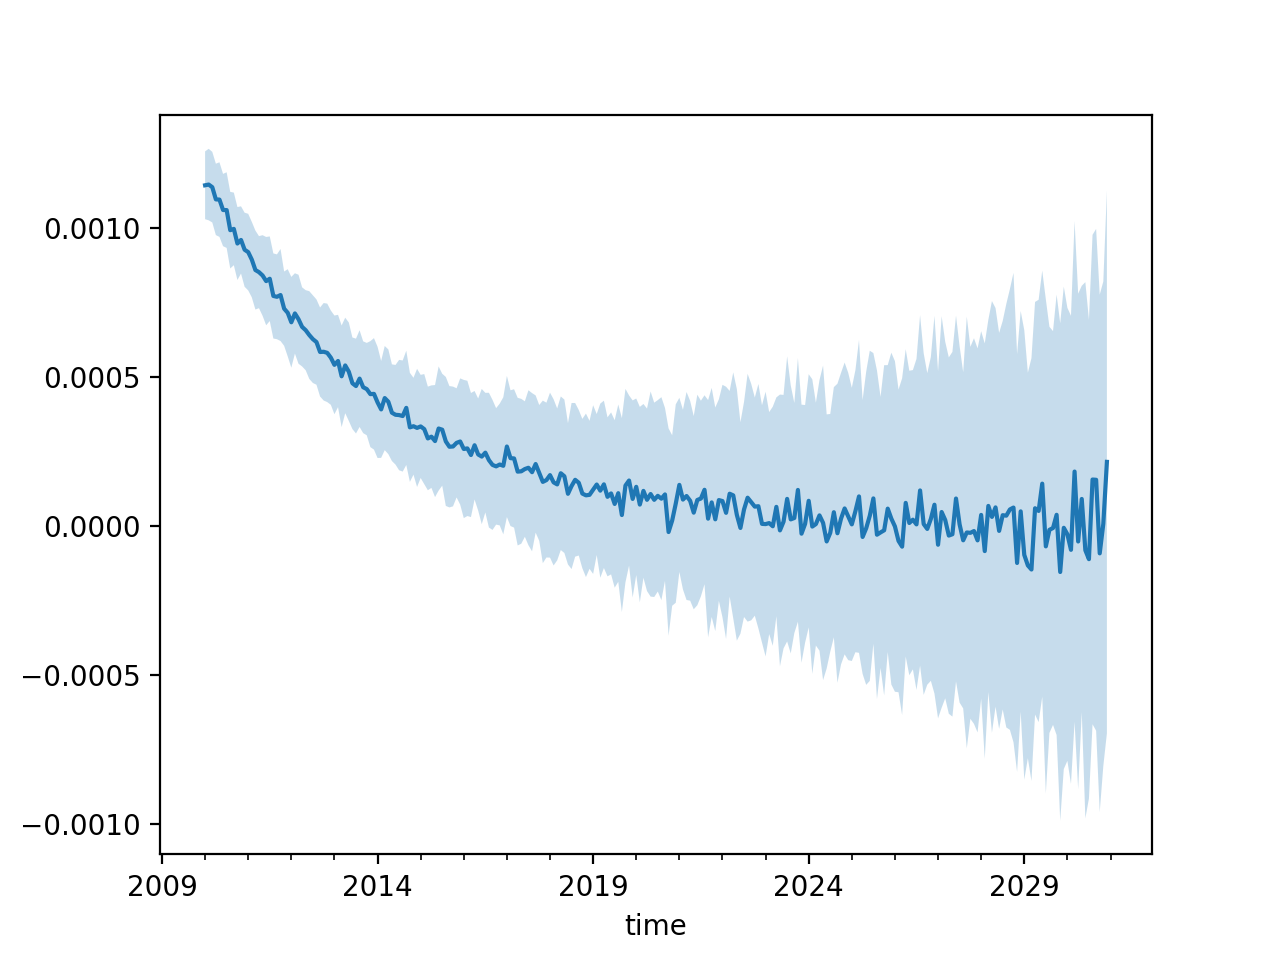

In [125]:
ax = _mean.plot()

In [126]:
ax.fill_between(df.index.unique(level='time'), _mean - _std, _mean +  _std, alpha=.25)

In [127]:
df['sigma'].where(df['sigma']<0).dropna().head(2)

time        samples
2013-03-01  61        -0.000015
2013-12-01  22        -0.000005
Name: sigma, dtype: float64

In [128]:

df['lci']=df['sigma'].groupby(level=['time']).quantile(.05)
df['uci']=df['sigma'].groupby(level=['time']).quantile(.95)